In [6]:
import pandas as pd
import numpy as np

# Load the datasets
train_meta = pd.read_csv("./train/train_metadata.csv")
train_add_features = pd.read_csv("./train/features/additional_features.csv")
train_color_hist = pd.read_csv("./train/features/color_histogram.csv")
train_hog_pca = pd.read_csv("./train/features/hog_pca.csv")

test_meta = pd.read_csv("./test/test_metadata.csv")
test_add_features = pd.read_csv("./test/features/additional_features.csv")
test_color_hist = pd.read_csv("./test/features/color_histogram.csv")
test_hog_pca = pd.read_csv("./test/features/hog_pca.csv")

In [7]:
# Merge datasets
train_df = pd.merge(train_meta, train_add_features, on="image_path", how="left")
train_df = pd.merge(train_df, train_color_hist, on="image_path", how="left")
train_df = pd.merge(train_df, train_hog_pca, on="image_path", how="left")

test_df = pd.merge(test_meta, test_add_features, on="image_path", how="left")
test_df = pd.merge(test_df, test_color_hist, on="image_path", how="left")
test_df = pd.merge(test_df, test_hog_pca, on="image_path", how="left")

# This is just better for reading files
train_df["image_path"] = train_df["image_path"].apply(lambda x: "train/" + x)
test_df["image_path"] = test_df["image_path"].apply(lambda x: "test/" + x)

In [8]:
train_df = train_df[["image_path", "ClassId", "id"]]
test_df = test_df[["image_path", "ClassId", "id"]]

# Prepare Data For CNN

In [9]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

# Debug to see if it GPU is available for boosting
print(tf.config.list_physical_devices("GPU"))

IMG_HEIGHT, IMG_WIDTH = 72, 72
CROP_SIZE = 3

def load_images(image_paths, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    images = []
    for path in image_paths:
        # Note pixels are stored in blue, green and red order
        pixels = cv2.imread(path)

        if pixels is None:
            continue

        # Crop the image from each side
        pixels = pixels[CROP_SIZE:-CROP_SIZE, CROP_SIZE:-CROP_SIZE]

        pixels = cv2.resize(pixels, (img_width, img_height))
        
        pixel_normalised = pixels.astype("float32") / 255.0
        b, g, r = cv2.split(pixel_normalised)
        
        # Use ratio to better emulate the perceived brightness, instead of just doing the average
        # https://en.wikipedia.org/wiki/Luma_(video)
        luma = 0.299 * r + 0.587 * g + 0.114 * b
        red_green = r - g
        blue_yellow = b - (r + g) / 2.0
        
        # Experiment with Sobel edge detection
        # https://www.geeksforgeeks.org/sobel-edge-detection-vs-canny-edge-detection-in-computer-vision/
        sobel_x = cv2.Sobel(luma, cv2.CV_32F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(luma, cv2.CV_32F, 0, 1, ksize=3)
        
        features = np.dstack((luma,
                              red_green,
                              blue_yellow))
                            #   sobel_x,
                            #   sobel_y))
        
        images.append(features)

    return np.array(images)

# Get image paths and labels from train_df
image_paths = train_df["image_path"].values
labels = train_df["ClassId"].values

# Load images
X_images = load_images(image_paths)

# Split the data
idx = np.arange(len(X_images))
train_idx, val_idx = train_test_split(
    idx,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

X_train_img = X_images[train_idx]
y_train_img = labels[train_idx]
X_val_img   = X_images[val_idx]
y_val_img   = labels[val_idx]

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Train CNN

In [10]:
# Data augmentation for better generalization
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    brightness_range=(0.6,1.4),
    zoom_range=0.2,
    shear_range=0.1,
    channel_shift_range=0.1,
)

def build_cnn_model(num_classes=43):
    # Load previously trained model
    # model = tf.keras.models.load_model("top_cnn_model.h5")

    # Layers inspired by common architectures like VGG
    # https://www.geeksforgeeks.org/convolutional-neural-network-cnn-architectures/
    # https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00444-8
    
    # We tried a combination of the layers and parameter values to see what works best
    # Also came across batch normalisation which helps improve performance
    # https://www.geeksforgeeks.org/what-is-batch-normalization-in-cnn/

    model = models.Sequential([
        # Block 1
        layers.Conv2D(
            32, (3, 3), activation="relu", padding="same",
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
        ),
        layers.BatchNormalization(),
        layers.Conv2D(
            32, (3, 3), activation="relu", padding="same",
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
        ),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(
            64, (3, 3), activation="relu", padding="same",
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
        ),
        layers.BatchNormalization(),
        layers.Conv2D(
            64, (3, 3), activation="relu", padding="same",
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
        ),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(
            128, (3, 3), activation="relu", padding="same",
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
        ),
        layers.BatchNormalization(),
        layers.Conv2D(
            128, (3, 3), activation="relu", padding="same",
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
        ),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Dense Layers
        layers.GlobalAveragePooling2D(),

        layers.Dense(
            # Tried 128 and 256, it seems 128 is better
            128, activation="relu",
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
        ),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(
            num_classes, activation="softmax",
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
        )
    ])
    
    return model

cnn_model = build_cnn_model()
cnn_model.compile(
    # Lower learning rate for better generalization
    optimizer= Adam(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Add callbacks
reduce_lr = ReduceLROnPlateau(
    # Monitor validation accuracy instead of loss
    monitor="val_accuracy",
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Add model checkpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    "best_cnn_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

# Smaller batch size for better generalization
BATCH_SIZE = 32

# Train model with focus on validation metrics
history = cnn_model.fit(
    X_train_img, y_train_img,
    # Uncomment line below to use data augmentation
    # datagen.flow(X_train_img, y_train_img, batch_size=BATCH_SIZE),
    # batch_size=32,
    validation_data=(X_val_img, y_val_img),
    epochs=50,  
    callbacks=[reduce_lr, early_stopping, checkpoint],
    verbose=1
)

# Load the best model saved during training
cnn_model = tf.keras.models.load_model("best_cnn_model.h5")

# Evaluate model
val_loss, val_acc = cnn_model.evaluate(X_val_img, y_val_img)
print(f"Validation accuracy: {val_acc:.4f}")

# Make predictions on test set
test_image_paths = test_df["image_path"].values
X_test_img = load_images(test_image_paths)
cnn_predictions = cnn_model.predict(X_test_img)
cnn_pred_classes = np.argmax(cnn_predictions, axis=1)

# Save CNN predictions
cnn_pred_df = pd.DataFrame({
    "id": test_df["id"], 
    "ClassId": cnn_pred_classes
})
cnn_pred_df.set_index("id", inplace=True)
cnn_pred_df.to_csv("cnn_predictions.csv")

/Users/micha31r/Documents/GitHub/ml-ass2/tf-metal/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-23 18:12:03.651859: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-05-23 18:12:03.652013: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-23 18:12:03.652025: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-23 18:12:03.652291: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-23 18:12:03.652313: I tensorflow/core/common_runtime/pluggable_device

Epoch 1/50


2025-05-23 18:12:05.836860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.0621 - loss: 4.3464
Epoch 1: val_accuracy improved from -inf to 0.06102, saving model to best_cnn_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.0623 - loss: 4.3442 - val_accuracy: 0.0610 - val_loss: 3.8880 - learning_rate: 5.0000e-04
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.1684 - loss: 3.5206
Epoch 2: val_accuracy did not improve from 0.06102
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.1684 - loss: 3.5203 - val_accuracy: 0.0528 - val_loss: 5.7315 - learning_rate: 5.0000e-04
Epoch 3/50
137/138 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2065 - loss: 3.1944
Epoch 3: val_accuracy improved from 0.06102 to 0.08197, saving model to best_cnn_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.2066 - loss: 3.1939 - val_accuracy: 0.0820 - val_loss: 6.9685 - learning_rate: 5.0000e-04
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2665 - loss: 2.8920
Epoch 4: val_accuracy improved from 0.08197 to 0.20036, saving model to best_cnn_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.2667 - loss: 2.8913 - val_accuracy: 0.2004 - val_loss: 4.4417 - learning_rate: 5.0000e-04
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3315 - loss: 2.5482
Epoch 5: val_accuracy improved from 0.20036 to 0.39435, saving model to best_cnn_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.3317 - loss: 2.5474 - val_accuracy: 0.3944 - val_loss: 2.4197 - learning_rate: 5.0000e-04
Epoch 6/50
137/138 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3964 - loss: 2.2138
Epoch 6: val_accuracy improved from 0.39435 to 0.43716, saving model to best_cnn_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.3967 - loss: 2.2128 - val_accuracy: 0.4372 - val_loss: 1.9393 - learning_rate: 5.0000e-04
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4720 - loss: 1.9026
Epoch 7: val_accuracy improved from 0.43716 to 0.59836, saving model to best_cnn_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.4720 - loss: 1.9023 - val_accuracy: 0.5984 - val_loss: 1.5282 - learning_rate: 5.0000e-04
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5822 - loss: 1.5388
Epoch 8: val_accuracy improved from 0.59836 to 0.64754, saving model to best_cnn_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5823 - loss: 1.5385 - val_accuracy: 0.6475 - val_loss: 1.4087 - learning_rate: 5.0000e-04
Epoch 9/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6791 - loss: 1.2499
Epoch 9: val_accuracy improved from 0.64754 to 0.78506, saving model to best_cnn_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.6793 - loss: 1.2493 - val_accuracy: 0.7851 - val_loss: 0.9777 - learning_rate: 5.0000e-04
Epoch 10/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7746 - loss: 0.9350
Epoch 10: val_accuracy improved from 0.78506 to 0.87158, saving model to best_cnn_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.7747 - loss: 0.9346 - val_accuracy: 0.8716 - val_loss: 0.6546 - learning_rate: 5.0000e-04
Epoch 11/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8485 - loss: 0.7275
Epoch 11: val_accuracy improved from 0.87158 to 0.89344, saving model to best_cnn_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.8486 - loss: 0.7272 - val_accuracy: 0.8934 - val_loss: 0.4970 - learning_rate: 5.0000e-04
Epoch 12/50
137/138 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9029 - loss: 0.5788
Epoch 12: val_accuracy improved from 0.89344 to 0.94900, saving model to best_cnn_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9031 - loss: 0.5783 - val_accuracy: 0.9490 - val_loss: 0.3644 - learning_rate: 5.0000e-04
Epoch 13/50
137/138 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9246 - loss: 0.4846
Epoch 13: val_accuracy did not improve from 0.94900
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9246 - loss: 0.4846 - val_accuracy: 0.9317 - val_loss: 0.4348 - learning_rate: 5.0000e-04
Epoch 14/50
137/138 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9426 - loss: 0.4356
Epoch 14: val_accuracy improved from 0.94900 to 0.96995, saving model to best_cnn_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9427 - loss: 0.4351 - val_accuracy: 0.9699 - val_loss: 0.2990 - learning_rate: 5.0000e-04
Epoch 15/50
137/138 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9514 - loss: 0.4006
Epoch 15: val_accuracy improved from 0.96995 to 0.97996, saving model to best_cnn_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9515 - loss: 0.4001 - val_accuracy: 0.9800 - val_loss: 0.2748 - learning_rate: 5.0000e-04
Epoch 16/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9742 - loss: 0.3157
Epoch 16: val_accuracy improved from 0.97996 to 0.98087, saving model to best_cnn_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9742 - loss: 0.3157 - val_accuracy: 0.9809 - val_loss: 0.2428 - learning_rate: 5.0000e-04
Epoch 17/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9667 - loss: 0.3312
Epoch 17: val_accuracy improved from 0.98087 to 0.99454, saving model to best_cnn_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.9667 - loss: 0.3310 - val_accuracy: 0.9945 - val_loss: 0.2109 - learning_rate: 5.0000e-04
Epoch 18/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9795 - loss: 0.2805
Epoch 18: val_accuracy did not improve from 0.99454
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9795 - loss: 0.2804 - val_accuracy: 0.9863 - val_loss: 0.2299 - learning_rate: 5.0000e-04
Epoch 19/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9882 - loss: 0.2471
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 19: val_accuracy did not improve from 0.99454
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9882 - loss: 0.2471 - val_accuracy: 0.9891 - val_loss: 0.2053 - learning_rate: 5.0000e-04
Epoch 20/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9914 - loss: 0.2276
Epoch 20: val_accuracy did not improve from 0.99454
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.9914 - 

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9950 - loss: 0.2029
Validation accuracy: 0.9945
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


## Plot Accuracy vs Epoch Graph

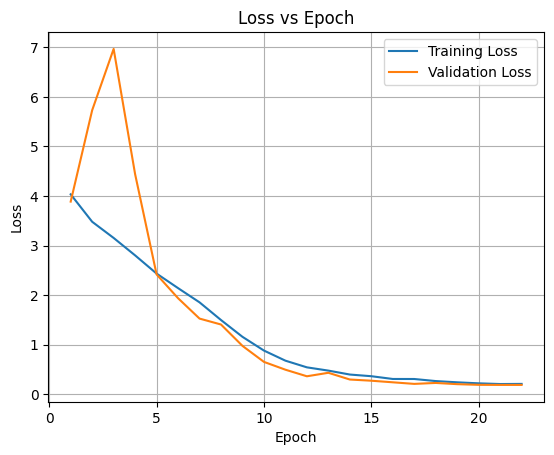

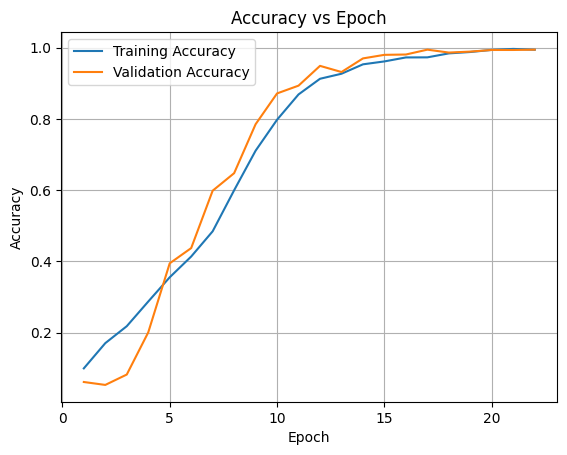

[0.09931662678718567, 0.1701594591140747, 0.2177676558494568, 0.2870159447193146, 0.3551252782344818, 0.41343963146209717, 0.4842824637889862, 0.5995444059371948, 0.7107061743736267, 0.7977221012115479, 0.868792712688446, 0.9127562642097473, 0.9268792867660522, 0.9533029794692993, 0.9615034461021423, 0.9726651310920715, 0.9728929400444031, 0.984054684638977, 0.9879270792007446, 0.9938496351242065, 0.9965831637382507, 0.9943052530288696]


In [11]:
import matplotlib.pyplot as plt

# Get the epochs so we know the range for x values
epochs = range(1, len(history.history["loss"]) + 1)

# Loss vs Epoch
plt.plot(epochs, history.history["loss"], label="Training Loss")
plt.plot(epochs, history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy vs Epoch
# Something to be aware of is that the accuracy will be lower if data augmentation is used
# This is because augmented images is more likely to be misclassified
plt.plot(epochs, history.history["accuracy"], label="Training Accuracy")
plt.plot(epochs, history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Just for testing
print(history.history["accuracy"])

# Show Misclassified Images From Validation

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Number of misclassifications: 1


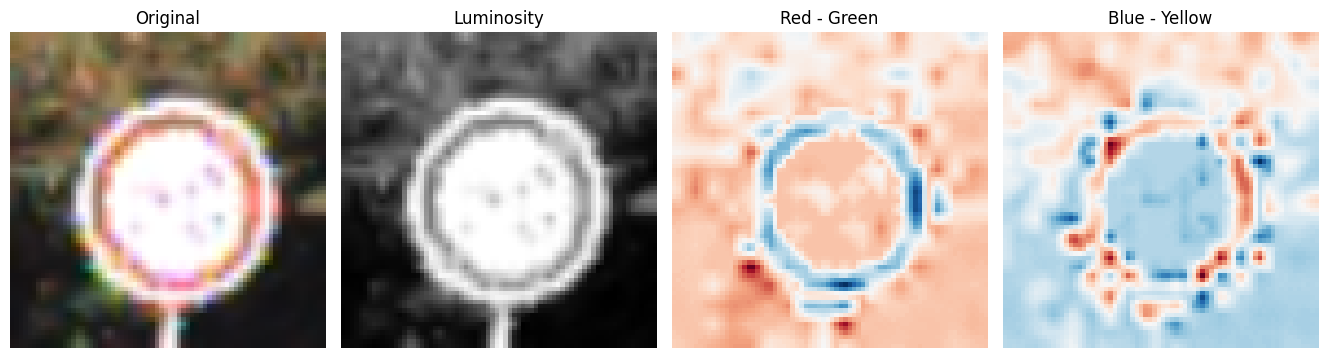

<Figure size 640x480 with 0 Axes>

In [12]:
from matplotlib import pyplot as plt

# Use the best model
cnn_model = tf.keras.models.load_model("top_cnn_model.h5")
probs = cnn_model.predict(X_val_img)
pred_indices = np.argmax(probs, axis=1)

validation_df = train_df.iloc[val_idx]
mismatches = validation_df[pred_indices != validation_df["ClassId"]]
num_images = len(mismatches)

print(f"Number of misclassifications: {num_images}")

plt.figure(figsize=(20, 4 * num_images))

for i, (_, row) in enumerate(mismatches.head(num_images).iterrows()):
    # Load and process image
    pixels = cv2.imread(row["image_path"])
    if pixels is None:
        continue

    pixels = cv2.resize(pixels, (IMG_WIDTH, IMG_HEIGHT)).astype("float32") / 255.0
    b, g, r = cv2.split(pixels)
    
    # Same code as previous section
    luma = 0.299 * r + 0.587 * g + 0.114 * b
    red_green = r - g
    blue_yellow = b - (r + g) / 2.0
    
    # Plot original image
    plt.subplot(num_images, 6, i * 6 + 1)
    plt.imshow(cv2.cvtColor((pixels * 255).astype("uint8"), cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")
    
    # Plot brightness
    plt.subplot(num_images, 6, i * 6 + 2)
    plt.imshow(luma, cmap="gray")
    plt.title("Luminosity")
    plt.axis("off")
    
    # Plot red-green
    plt.subplot(num_images, 6, i * 6 + 3)
    plt.imshow(red_green, cmap="RdBu")
    plt.title("Red - Green")
    plt.axis("off")
    
    # Plot blue-yellow
    plt.subplot(num_images, 6, i * 6 + 4)
    plt.imshow(blue_yellow, cmap="RdBu")
    plt.title("Blue - Yellow")
    plt.axis("off")

plt.tight_layout()
plt.show()

plt.savefig("mismatched_images.png")
mismatches.to_csv("mismatched_images.csv")